In [1]:
#pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

一、 准备数据

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text major ticklabel objects>)

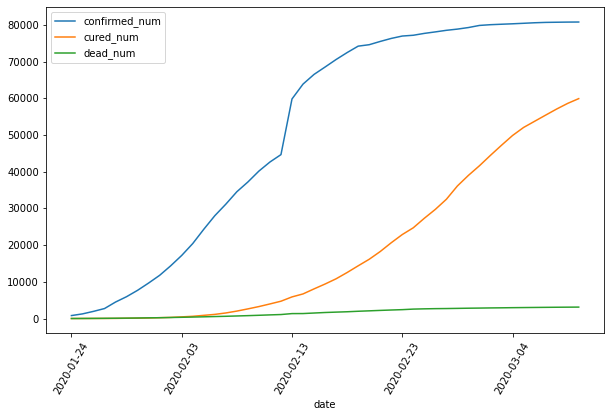

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./data/covid-19.csv', sep='\t')
df.plot(x='date', y=['confirmed_num', 'cured_num', 'dead_num'], figsize=(10,6))
plt.xticks(rotation=60)

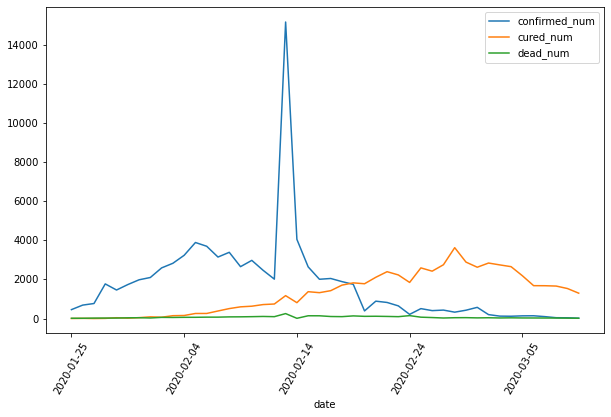

In [3]:
df_data = df.set_index('date')
df_diff = df_data.diff(periods=1).dropna()
df_diff = df_diff.reset_index('date')

df_diff.plot(x='date', y=['confirmed_num', 'cured_num', 'dead_num'], figsize=(10,6))
plt.xticks(rotation=60)

df_diff = df_diff.drop('date', axis=1).astype('float32')

In [4]:
df_diff.head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


下面我们通过继承torch.utils.data.Dataset实现自定义时间序列数据集。

torch.utils.data.Dataset是一个抽象类，用户想要加载自定义的数据只需要继承这个类，并且覆写其中的两个方法即可：

__len__:实现len(dataset)返回整个数据集的大小。
__getitem__:用来获取一些索引的数据，使dataset[i]返回数据集中第i个样本。

不覆写这两个方法会直接返回错误。

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 用某日前8 天窗口数据，作为输入， 预测改日数据
WINDOW_SIZE = 8

class Covid19Dataset(Dataset):

    def __len__(self):
        return len(df_diff) - WINDOW_SIZE

    def __getitem__(self, i):
        x = df_diff.loc[i:i+WINDOW_SIZE-1, :]
        feature = torch.tensor(x.values)
        y = df_diff.loc[i+WINDOW_SIZE, :]
        label = torch.tensor(y.values)
        return feature, label


ds_train = Covid19Dataset()

# 数据比较小， 可以将全部训练数据放到一个batch 中，提升性能
dl_train = DataLoader(ds_train, batch_size=38)


二、 定义模型
使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择第二种方式构建模型。

由于接下来使用类形式的训练循环，我们进一步将模型封装成torchkeras中的Model类来获得类似Keras中高阶模型接口的功能。

Model类实际上继承自nn.Module类。

In [13]:
import torch
from torch import nn
import importlib
import torchkeras

torch.random.seed()

class Block(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, x_input):
        x_out = torch.max((1+x)*x_input[:, -1, :], torch.tensor(0.0))
        return x_out


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 层lstm
        self.lstm = nn.LSTM(input_size=3, hidden_size=3, num_layers=5, batch_first=True)
        self.linear = nn.Linear(3, 3)
        self.block = Block()

    def forward(self, x_input):
        x = self.lstm(x_input)[0][:, -1, :]
        x = self.linear(x)
        y = self.block(x, x_input)
        return y

net = Net()
model = torchkeras.Model(net)
print(model)

model.summary(input_shape=(8,3), input_dtype=torch.FloatTensor)

Model(
  (net): Net(
    (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
    (linear): Linear(in_features=3, out_features=3, bias=True)
    (block): Block()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                 [-1, 8, 3]             480
            Linear-2                    [-1, 3]              12
             Block-3                    [-1, 3]               0
Total params: 492
Trainable params: 492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000092
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002197
----------------------------------------------------------------


三、 训练模型
训练Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种类形式的训练循环。

我们仿照Keras定义了一个高阶的模型接口Model,实现 fit, validate，predict, summary 方法，相当于用户自定义高阶API。

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [27]:

def mspe(y_pred, y_true):
    err_percent = (y_true - y_pred)**2 / (torch.max(y_true**2, torch.tensor(1e-7)))
    # err_percent = (y_true - y_pred)**2/(torch.max(y_true**2,torch.tensor(1e-7)))
    return torch.mean(err_percent)

model.compile(loss_func=mspe, optimizer=torch.optim.Adam(model.parameters(), lr=0.1))

In [28]:
dfhistory = model.fit(100, dl_train, log_step_freq=10)

Start Training ...

================================================================================2020-10-13 14:30:00

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   1   | 1.676 |
+-------+-------+

================================================================================2020-10-13 14:30:00

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 0.762 |
+-------+-------+

================================================================================2020-10-13 14:30:00

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   3   | 0.426 |
+-------+-------+

================================================================================2020-10-13 14:30:00

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   4   | 0.531 |
+-------+-------+

================================================================================2020-10-13 14:30:00

 +-------+------+
| epoch | loss |
+-------+------+
|   5   | 0.47 |
+-------+------+

====================

四、 评估模型
评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [29]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

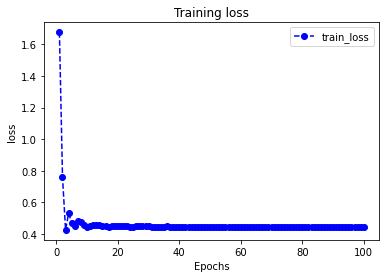

In [30]:
plot_metric(dfhistory, 'loss')

五、 使用模型
此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [31]:
#使用dfresult记录现有数据以及此后预测的疫情数据

df_result = df_diff[['confirmed_num', 'cured_num', 'dead_num']].copy()
df_result.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [32]:
#预测此后200天的新增走势,将其结果添加到dfresult中

for i in range(200):
    arr_input = torch.unsqueeze(torch.from_numpy(df_result.values[-38: , :]), axis=0)
    arr_pred = model.forward(arr_input)

    dfpredict = pd.DataFrame(torch.floor(arr_pred).data.numpy(), columns=df_result.columns)

    df_result = df_result.append(dfpredict, ignore_index=True)

In [33]:
df_result.query('confirmed_num==0').head()
# 第50天开始新增确诊降为0，第45天对应3月10日，也就是5天后，即预计3月15日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
50,0.0,1262.0,0.0
51,0.0,1255.0,-0.0
52,0.0,1248.0,0.0
53,0.0,1241.0,-0.0
54,0.0,1234.0,0.0


In [36]:
df_result.query('cured_num==0').head()

,confirmed_num,cured_num,dead_num


In [35]:
df_result.query('dead_num==0').head()
# 第50天开始新增确诊降为0，第45天对应3月10日，也就是5天后，即预计3月15日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
46,9.0,1290.0,0.0
47,4.0,1283.0,-0.0
48,2.0,1276.0,0.0
49,1.0,1269.0,-0.0
50,0.0,1262.0,0.0


六、 保存模型
推荐使用保存参数方式保存Pytorch模型。

In [38]:
# 保存模型参数

torch.save(model.net.state_dict(), './data/seq_model_parameter.pkl')

net_clone = Net()
net_clone.load_state_dict(torch.load('./data/seq_model_parameter.pkl'))
model_clone = torchkeras.Model(net_clone)
model_clone.compile(loss_func=mspe)

In [39]:
# 评估模型
model_clone.evaluate(dl_train)

{'val_loss': 0.4466840922832489}